# Aperiodic electrophysiological activity tracks spiking statistics between behavioral states
Sawyer Figueroa, Michael Preston, Bradley Voytek

# SfN 2023, Poster Panel 
This notebook reproduces the figures from poster panel 5. Panel 5 investigates the relationship between spike-synchrony and aperiodic LFP activity. Spiking and spectral parameters are quantified with high temporal resolution in order to elucidate dynamic changes on the timescale of miliseconds. 

#

Dataset: Allen Institute for Brain Science: Visual Coding - Neuropixels  
© 2015 Allen Institute for Brain Science. Allen Brain Atlas API. Available from: https://portal.brain-map.org/explore/circuits/visual-coding-neuropixels

## Set-up

### set paths

In [3]:
# set paths
PROJECT_PATH = "G:/Shared drives/visual_encoding" # shared results directory
MANIFEST_PATH = 'D:/datasets/allen_vc' # path to manifest file and local dataset

### imports

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Imports
import pandas as pd
import numpy as np
import neo
import quantities as pq
from elephant.statistics import instantaneous_rate
from elephant import kernels
import matplotlib.pyplot as plt
from matplotlib import rcParams
import sys
import os
from time import time as timer

In [8]:
# custom imports
import sys
sys.path.append('../../')

from allen_vc.plots import plot_linregress, plot_time_resolved_params
from allen_vc.utils import print_time_elapsed

print("Packages Imported")

Packages Imported


### settings

In [ ]:
# matplotlib and figure appearance settings
plt.style.use(f'../../stylelib/sfn_2023.mplstyle')
# COLORS = ["#7570b3", "#3FAA96", "#F39943"]

### load data

In [11]:
# concatenate param data
dfs = []
for file in os.listdir(f'{PROJECT_PATH}/data/lfp_data/params/tfr/natural_movie_one_more_repeats/knee/by_session'):
    dfs.append(pd.read_csv(f'{PROJECT_PATH}/data/lfp_data/params/tfr/natural_movie_one_more_repeats/knee/by_session/{file}'))

all_chans = pd.concat(dfs)

FYI: The above results can typically be imported directly '<project_path>/lfp_data/params/tfr/<stim_code>/lfp_params.csv'

## Main

### ~

In [12]:
# median across channels
params = all_chans.groupby(['session', 'epoch_idx', 'window_idx']).median().drop(['chan_idx'], axis=1).reset_index()
params.head()

,session,epoch_idx,window_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,pw_1,bw_1,cf_2,pw_2,bw_2,cf_3,pw_3,bw_3,error,r_squared
0,766640955,1,0,-4.115208,9.968530,2.423561,64.467576,1.233282,9.732393,94.041406,1.385570,3.384751,118.799761,1.332603,5.113630,132.435563,1.289509,10.118157,0.330113,0.885538
1,766640955,1,1,-3.954905,11.661401,2.582745,63.642010,1.232250,7.163074,99.365796,1.274334,3.202332,118.969208,1.249717,5.786398,131.225242,1.119601,11.121559,0.320669,0.891436
2,766640955,1,2,-3.810811,7.437185,2.646690,61.905297,1.044139,19.982444,114.950307,1.235087,7.364720,122.320409,1.268337,7.544635,132.205563,1.122866,10.364844,0.302633,0.903953
3,766640955,1,3,-3.675141,9.884550,2.679084,61.592062,1.109199,5.776820,73.793539,1.214822,8.454238,118.174816,1.244945,12.379198,132.435563,1.193891,11.217565,0.304857,0.901293
4,766640955,1,4,-3.742768,9.195486,2.637796,49.367178,1.149908,5.723401,74.629031,1.201398,7.115478,118.733133,1.198596,6.158769,131.744733,1.130073,12.123564,0.318002,0.898060


In [19]:
# use sliding window with same window size used for param calculation
window_size = 0.02*pq.s
region = 'VISp'

# init - add results to params dataframe
params['inst_spike_rate'] = np.nan
params['avg_pupil_area'] = np.nan

# time it
start = timer()

# loop over sessions
for i_ses, ses_id in enumerate(params['session'].unique()):
    print(f"Computing session: {ses_id} ({i_ses+1}/{len(params['session'].unique())})")

    # load session data
    block = neo.io.NeoMatlabIO(f'{PROJECT_PATH}/data/blocks/segmented/natural_movie_one_more_repeats/block_{ses_id}.mat').read_block()
    seg = block.segments[0]
    spiketrains = seg.filter({'brain_structure': region}, objects=neo.SpikeTrain) # get only LGd units
    
    # init
    seg_pupil_area = []
    i = seg.annotations['stimulus_onset']*pq.s
    
    # loop over sliding window
    while i <= seg.t_stop - window_size:
        
        # calculate average pupil area over window
        if len(seg.analogsignals) > 1:
            seg_pupil_area.append(np.mean(seg.analogsignals[1].time_slice(i, i+window_size)))
        else:
            seg_pupil_area.append(np.nan)
        
        # increment window
        i += window_size
        
    seg_rates = instantaneous_rate(block.segments[0].spiketrains, sampling_period=0.02*pq.s, kernel=kernels.GaussianKernel(sigma=0.01*pq.s)).magnitude.mean(axis=1)

    # add segment data to params dataframe
    params.loc[params['session']==ses_id, 'inst_spike_rate'] = seg_rates
    params.loc[params['session']==ses_id, 'avg_pupil_area'] = seg_pupil_area

# save/show results
params.to_csv(f'{PROJECT_PATH}/data/lfp_data/params/tfr/natural_movie_one_more_repeats/knee/params_{region}.csv', index=False)
print_time_elapsed(start)
params.head()

Computing session: 766640955 (1/21)
Computing session: 767871931 (2/21)
Computing session: 771160300 (3/21)
Computing session: 771990200 (4/21)
Computing session: 774875821 (5/21)
Computing session: 778240327 (6/21)
Computing session: 778998620 (7/21)
Computing session: 779839471 (8/21)
Computing session: 781842082 (9/21)
Computing session: 786091066 (10/21)
Computing session: 787025148 (11/21)
Computing session: 789848216 (12/21)
Computing session: 793224716 (13/21)
Computing session: 794812542 (14/21)
Computing session: 816200189 (15/21)
Computing session: 821695405 (16/21)
Computing session: 829720705 (17/21)
Computing session: 831882777 (18/21)
Computing session: 835479236 (19/21)
Computing session: 839068429 (20/21)
Computing session: 847657808 (21/21)
0 hours, 2 minutes, and 16.1 seconds


,session,epoch_idx,window_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,...,cf_2,pw_2,bw_2,cf_3,pw_3,bw_3,error,r_squared,inst_spike_rate,avg_pupil_area
0,766640955,1,0,-4.115208,9.968530,2.423561,64.467576,1.233282,9.732393,94.041406,...,118.799761,1.332603,5.113630,132.435563,1.289509,10.118157,0.330113,0.885538,6.890164,0.002671
1,766640955,1,1,-3.954905,11.661401,2.582745,63.642010,1.232250,7.163074,99.365796,...,118.969208,1.249717,5.786398,131.225242,1.119601,11.121559,0.320669,0.891436,9.994018,0.002669
2,766640955,1,2,-3.810811,7.437185,2.646690,61.905297,1.044139,19.982444,114.950307,...,122.320409,1.268337,7.544635,132.205563,1.122866,10.364844,0.302633,0.903953,13.209770,0.002682
3,766640955,1,3,-3.675141,9.884550,2.679084,61.592062,1.109199,5.776820,73.793539,...,118.174816,1.244945,12.379198,132.435563,1.193891,11.217565,0.304857,0.901293,12.206672,0.002681
4,766640955,1,4,-3.742768,9.195486,2.637796,49.367178,1.149908,5.723401,74.629031,...,118.733133,1.198596,6.158769,131.744733,1.130073,12.123564,0.318002,0.898060,12.291633,0.002670


In [20]:
# load/concat results from cell above
vis_in = f'{PROJECT_PATH}/data/lfp_data/params/tfr/natural_movie_one_more_repeats/knee/params_VISp.csv'
params = pd.read_csv(vis_in).dropna(axis=0,subset=['avg_pupil_area', 'inst_spike_rate']) # drop null values for pupil area and spike rate
params.head()

,session,epoch_idx,window_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,...,cf_2,pw_2,bw_2,cf_3,pw_3,bw_3,error,r_squared,inst_spike_rate,avg_pupil_area
0,766640955,1,0,-4.115208,9.968530,2.423561,64.467576,1.233282,9.732393,94.041406,...,118.799761,1.332603,5.113630,132.435563,1.289509,10.118157,0.330113,0.885538,6.890164,0.002671
1,766640955,1,1,-3.954905,11.661401,2.582745,63.642010,1.232250,7.163074,99.365796,...,118.969208,1.249717,5.786398,131.225242,1.119601,11.121559,0.320669,0.891436,9.994018,0.002669
2,766640955,1,2,-3.810811,7.437185,2.646690,61.905297,1.044139,19.982444,114.950307,...,122.320409,1.268337,7.544635,132.205563,1.122866,10.364844,0.302633,0.903953,13.209770,0.002682
3,766640955,1,3,-3.675141,9.884550,2.679084,61.592062,1.109199,5.776820,73.793539,...,118.174816,1.244945,12.379198,132.435563,1.193891,11.217565,0.304857,0.901293,12.206672,0.002681
4,766640955,1,4,-3.742768,9.195486,2.637796,49.367178,1.149908,5.723401,74.629031,...,118.733133,1.198596,6.158769,131.744733,1.130073,12.123564,0.318002,0.898060,12.291633,0.002670


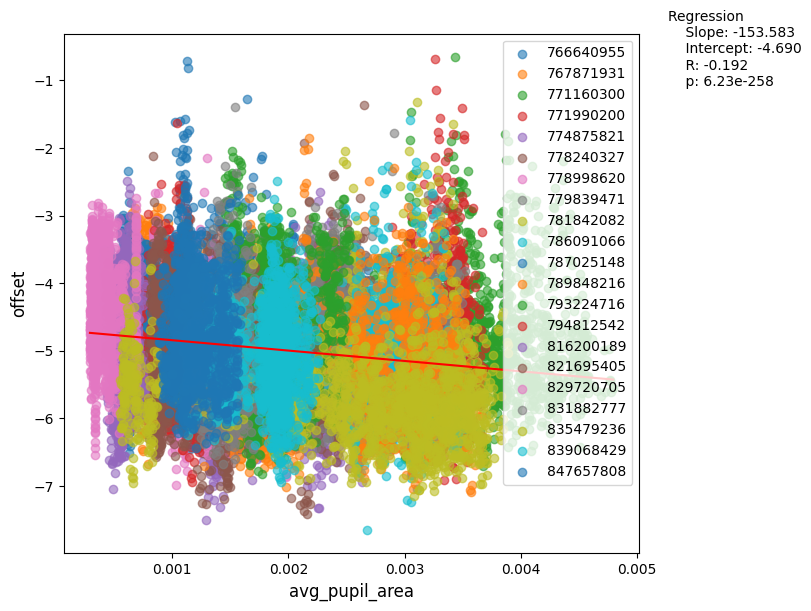

In [21]:
plot_linregress(params, 'avg_pupil_area', 'offset', group='session', show=True)

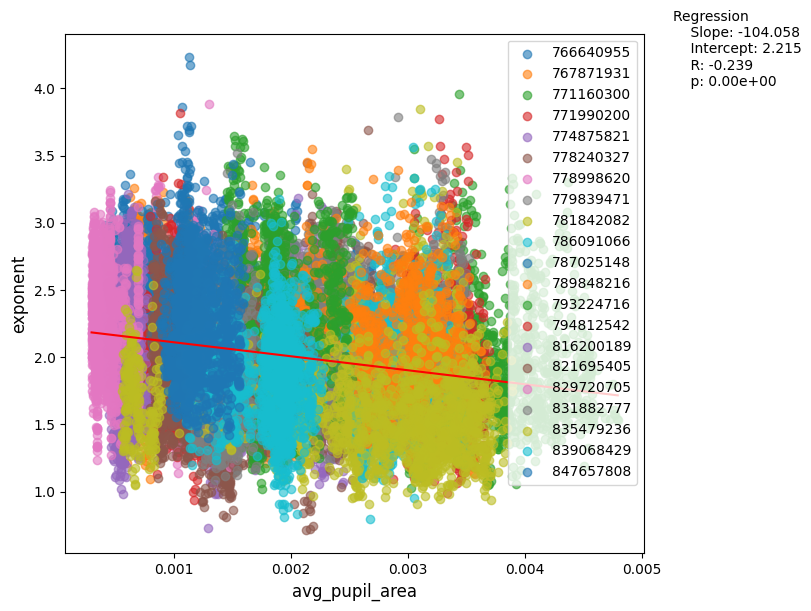

In [22]:
plot_linregress(params, 'avg_pupil_area', 'exponent', group='session', show=True)

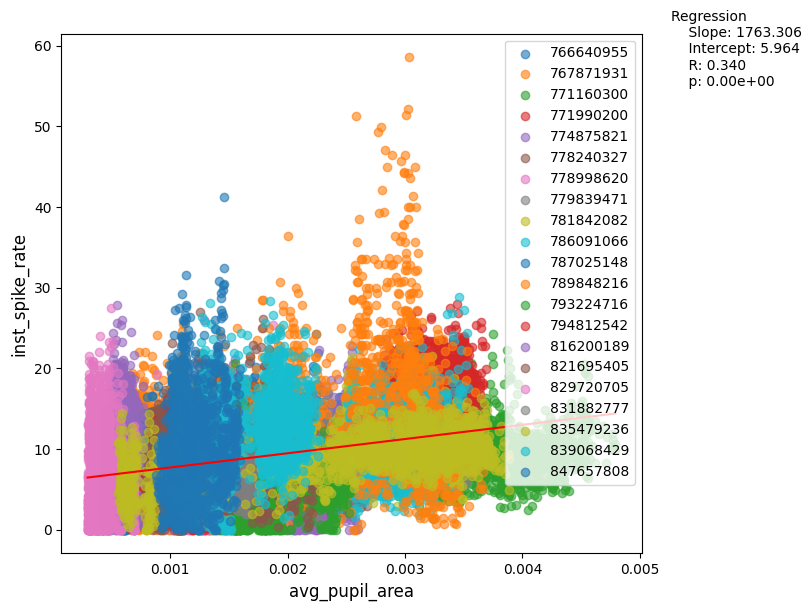

In [23]:
plot_linregress(params, 'avg_pupil_area', 'inst_spike_rate', group='session', show=True)

### Parameter time series

In [ ]:
'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

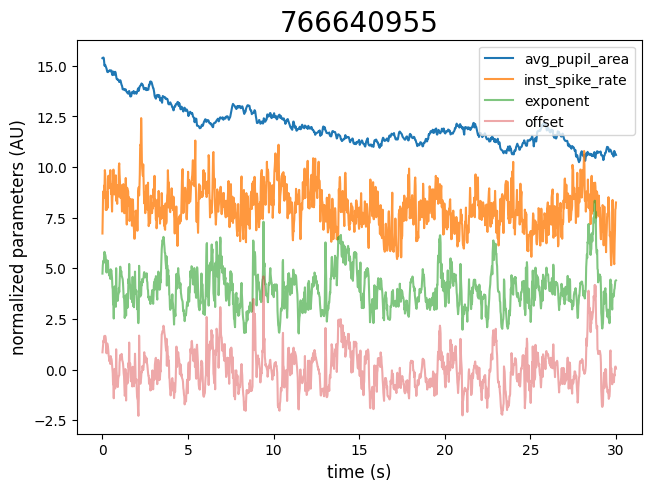

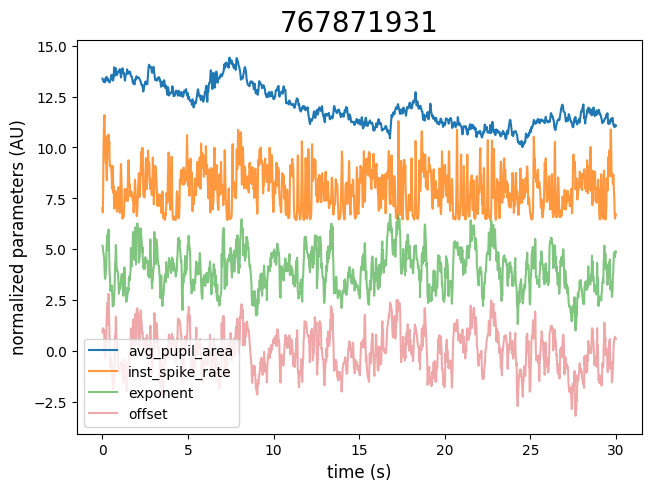

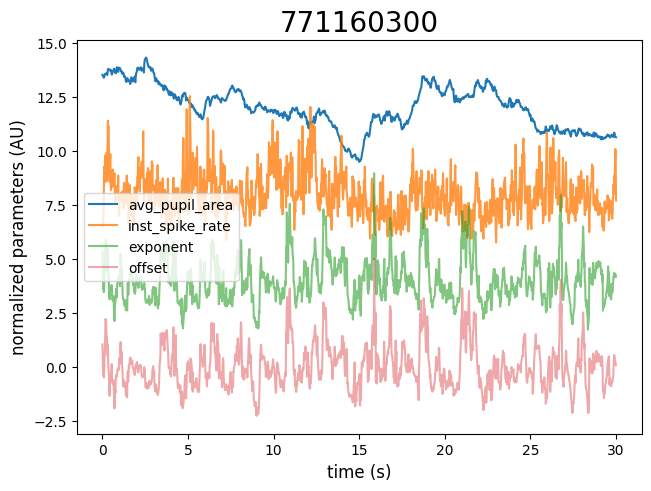

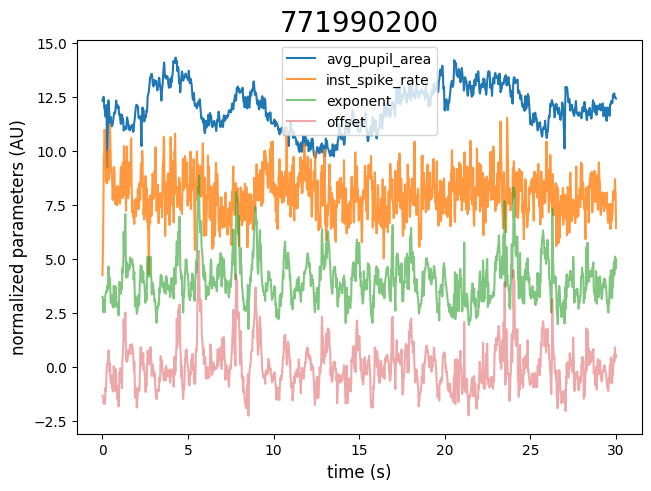

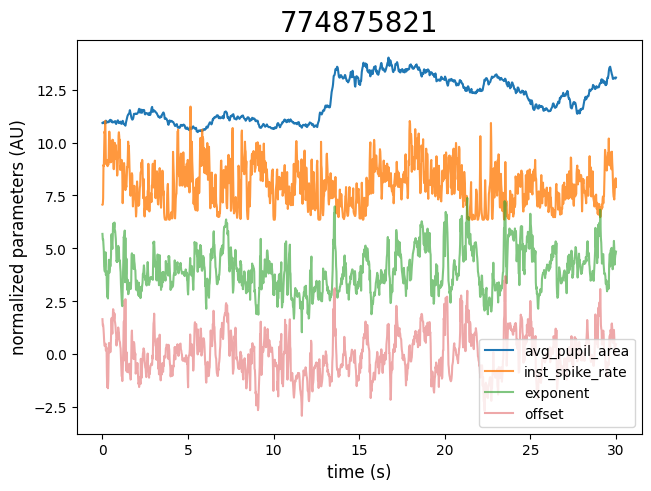

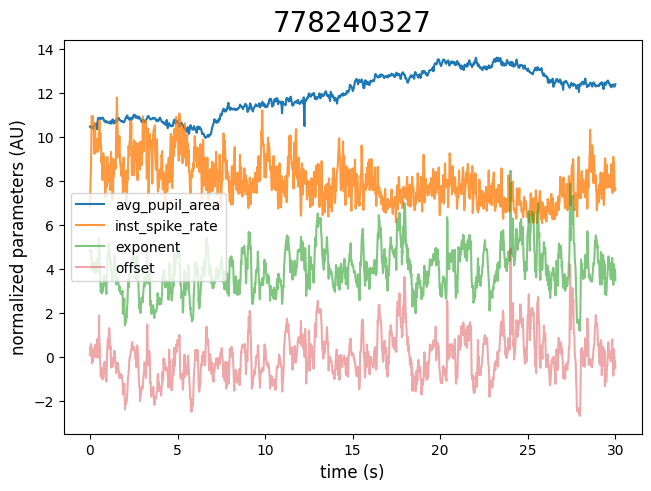

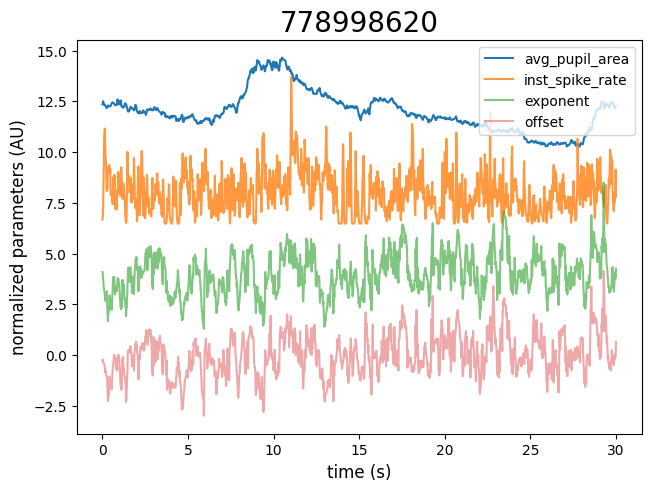

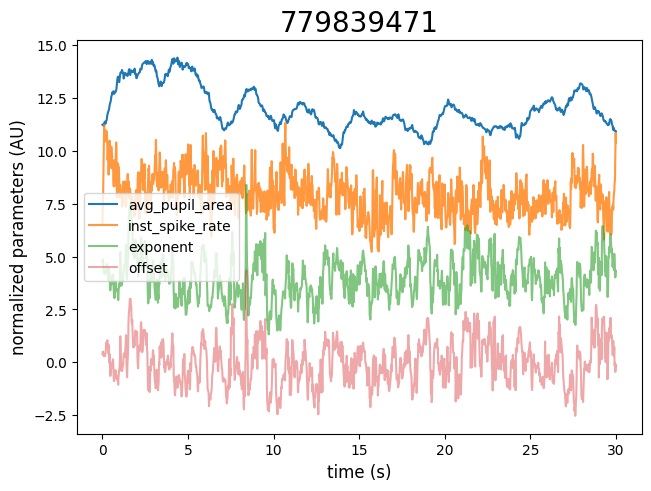

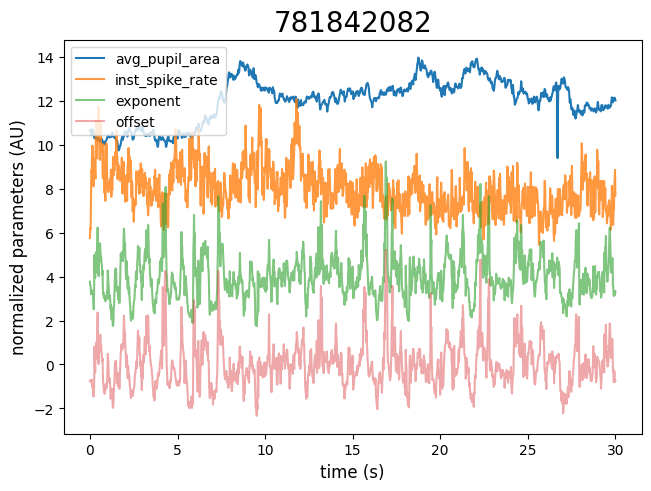

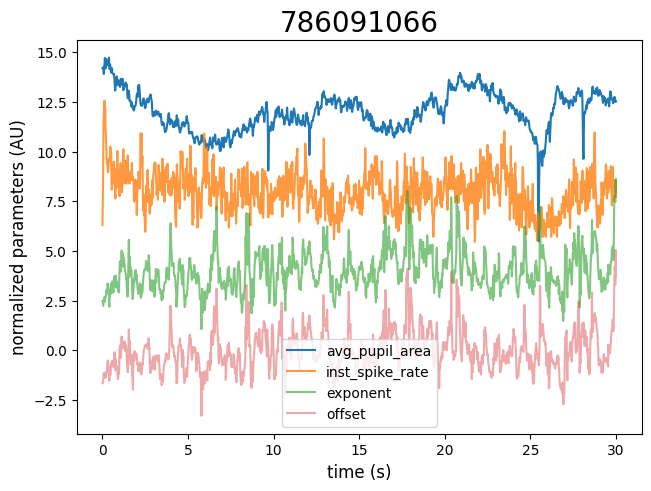

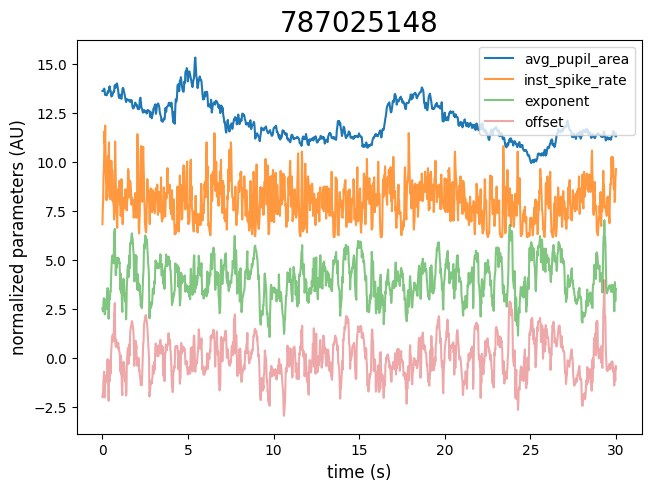

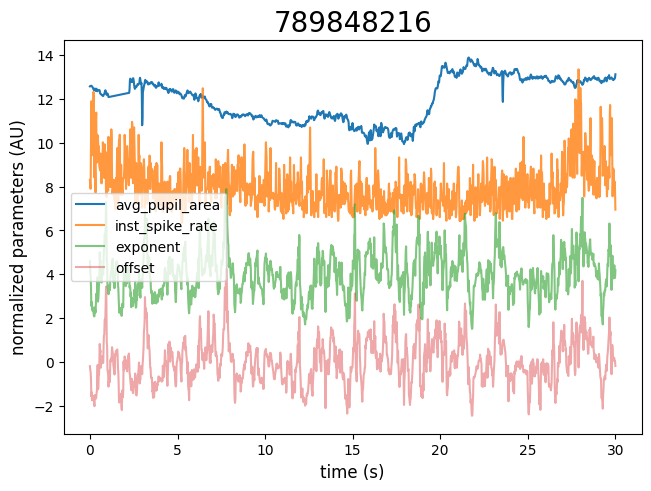

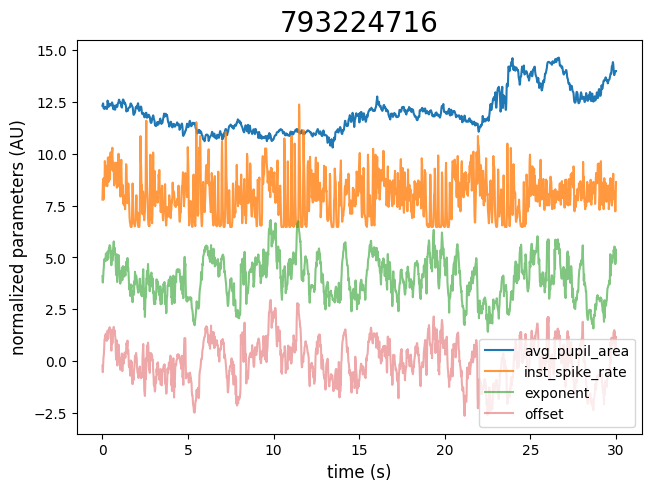

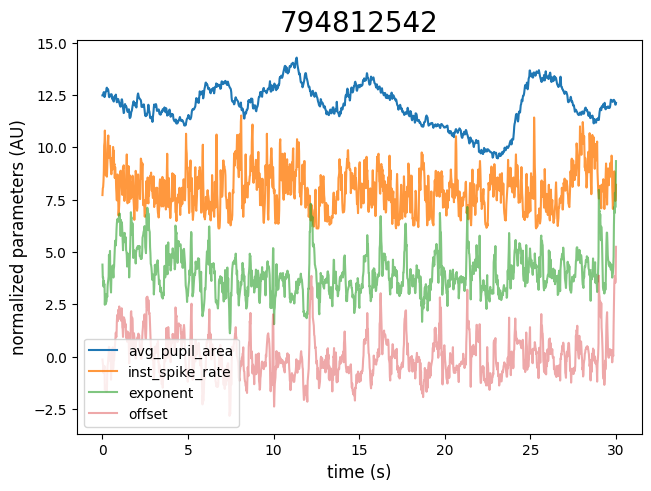

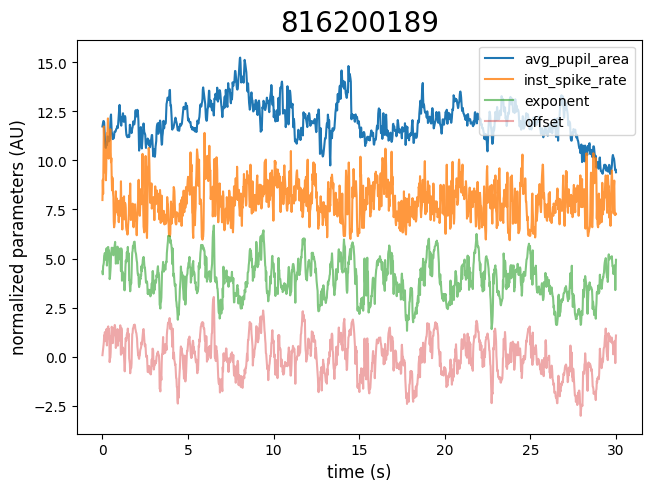

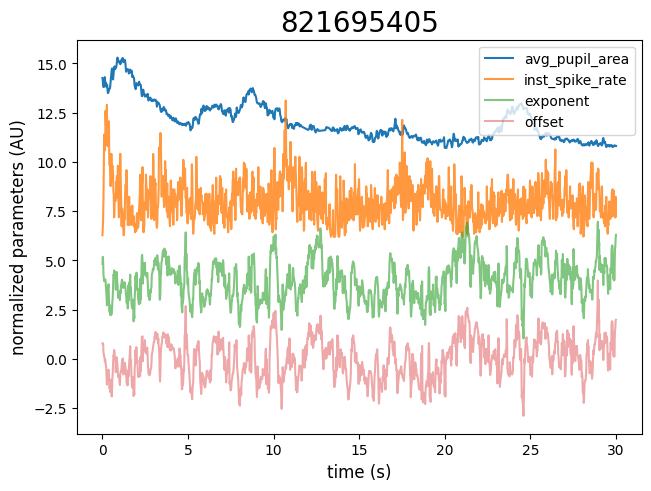

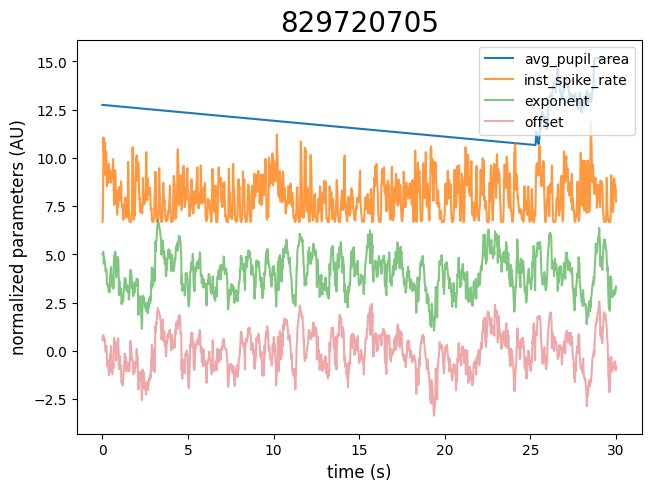

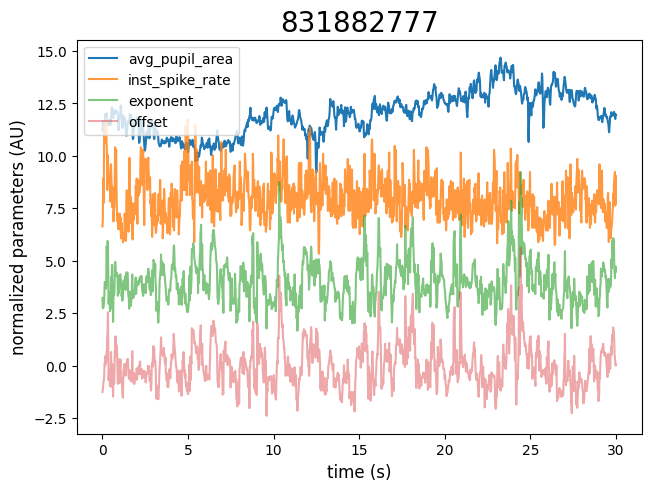

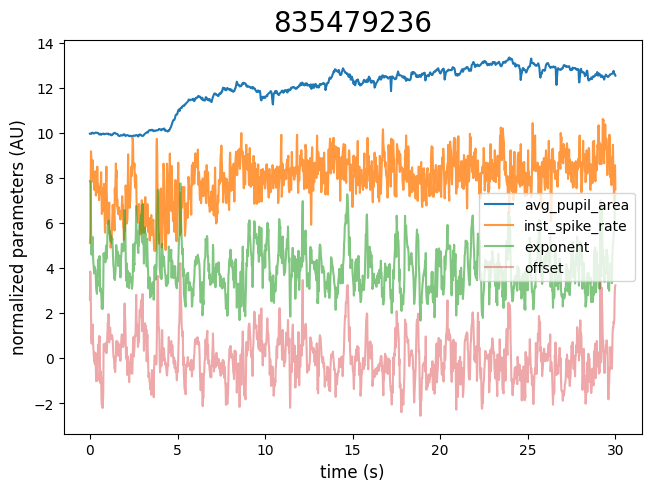

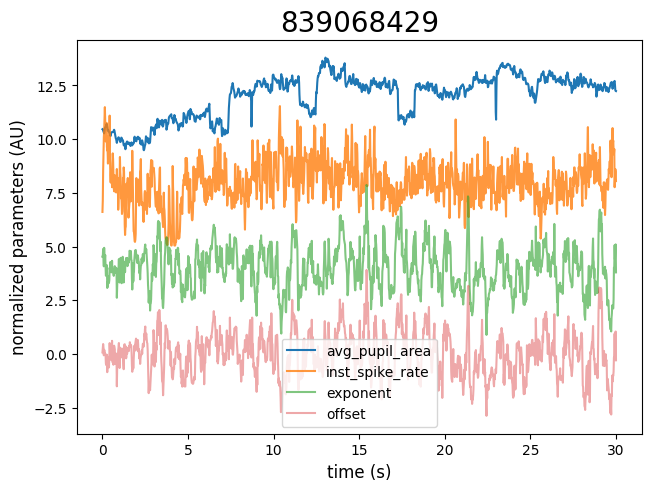

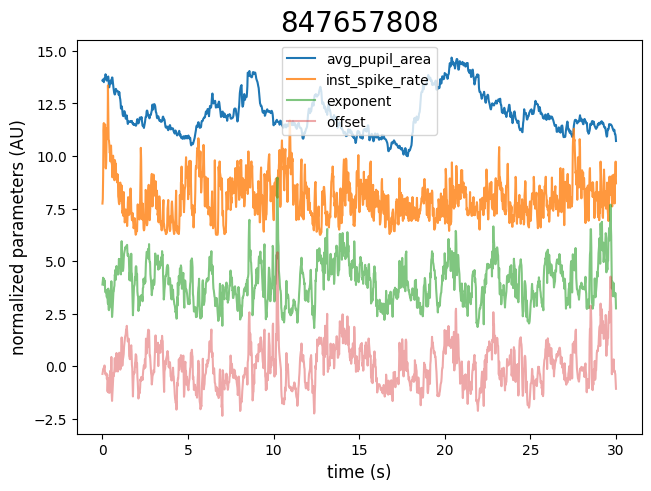

In [43]:
plot_time_resolved_params(params, 0.02)